In [5]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Law of large numbers (Page 82 - Section 3.1.2)

In the previous notebook, we replicated the Monte Carlo simulation in the book for finding the difference in infection rates (n=100). The result obtained in the book was 2%, in our simulation it was 1%. If you repeat this simulation, you might even see 0%. Then, I increased n from 100 to 1 million and obtained ~1.2%. If you repeat the simulation with n=1e6 you will still see a fluctuation, but much less. This the law of large numbers.

>LAW OF LARGE NUMBERS
>
>As more observations are collected, the proportion pˆn of occurrences with a particular >outcome converges to the probability p of that outcome.

EXERCISE

Page 82:

>Probability can be illustrated by rolling a die many times. Let $p^n$ be the proportion of >outcomes that are 1 after the first n rolls. As the number of rolls increases, $p^n$ will >converge to the probability of rolling a 1, p = 1/6. Figure 3.1 shows this convergence for >100,000 die rolls. The tendency of $p^n$ to stabilize around p is described by the Law of Large Numbers.

Construct this Monte Carlo simulation and plot a similar figure like Figure 3.1. Note that x-axis is in log scale. The solution is available below, but try yourself first.

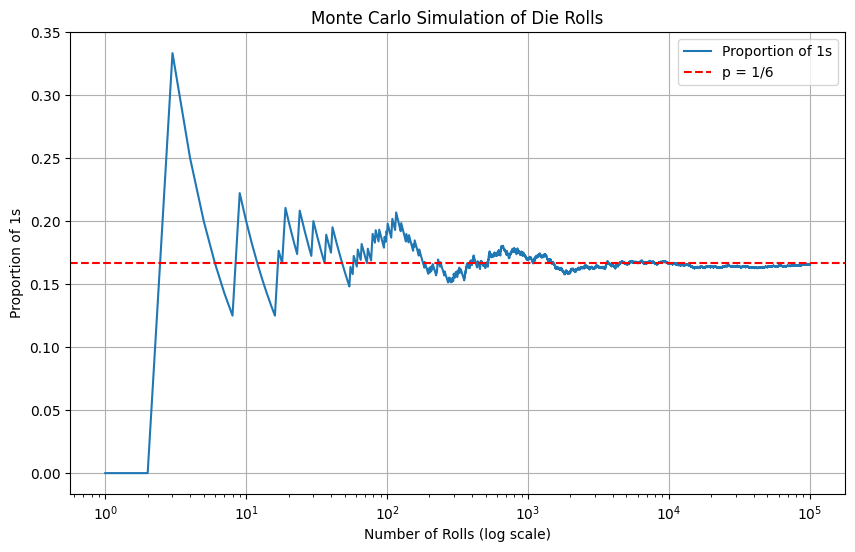

In [2]:
# YOUR CODE HERE

# Set the total number of die rolls
n_rolls = 100000
# Perform Monte Carlo simulation by rolling the die n_rolls times
rolls = np.random.randint(1, 7, size=n_rolls)
# Calculate the proportion of outcomes that are 1 after each roll
proportions = np.cumsum(rolls == 1) / np.arange(1, n_rolls + 1)
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, n_rolls + 1), proportions, label="Proportion of 1s")
plt.axhline(y=1/6, color='r', linestyle='--', label="p = 1/6")

# Customize the plot
plt.xscale('log')
plt.xlabel("Number of Rolls (log scale)")
plt.ylabel("Proportion of 1s")
plt.title("Monte Carlo Simulation of Die Rolls")
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

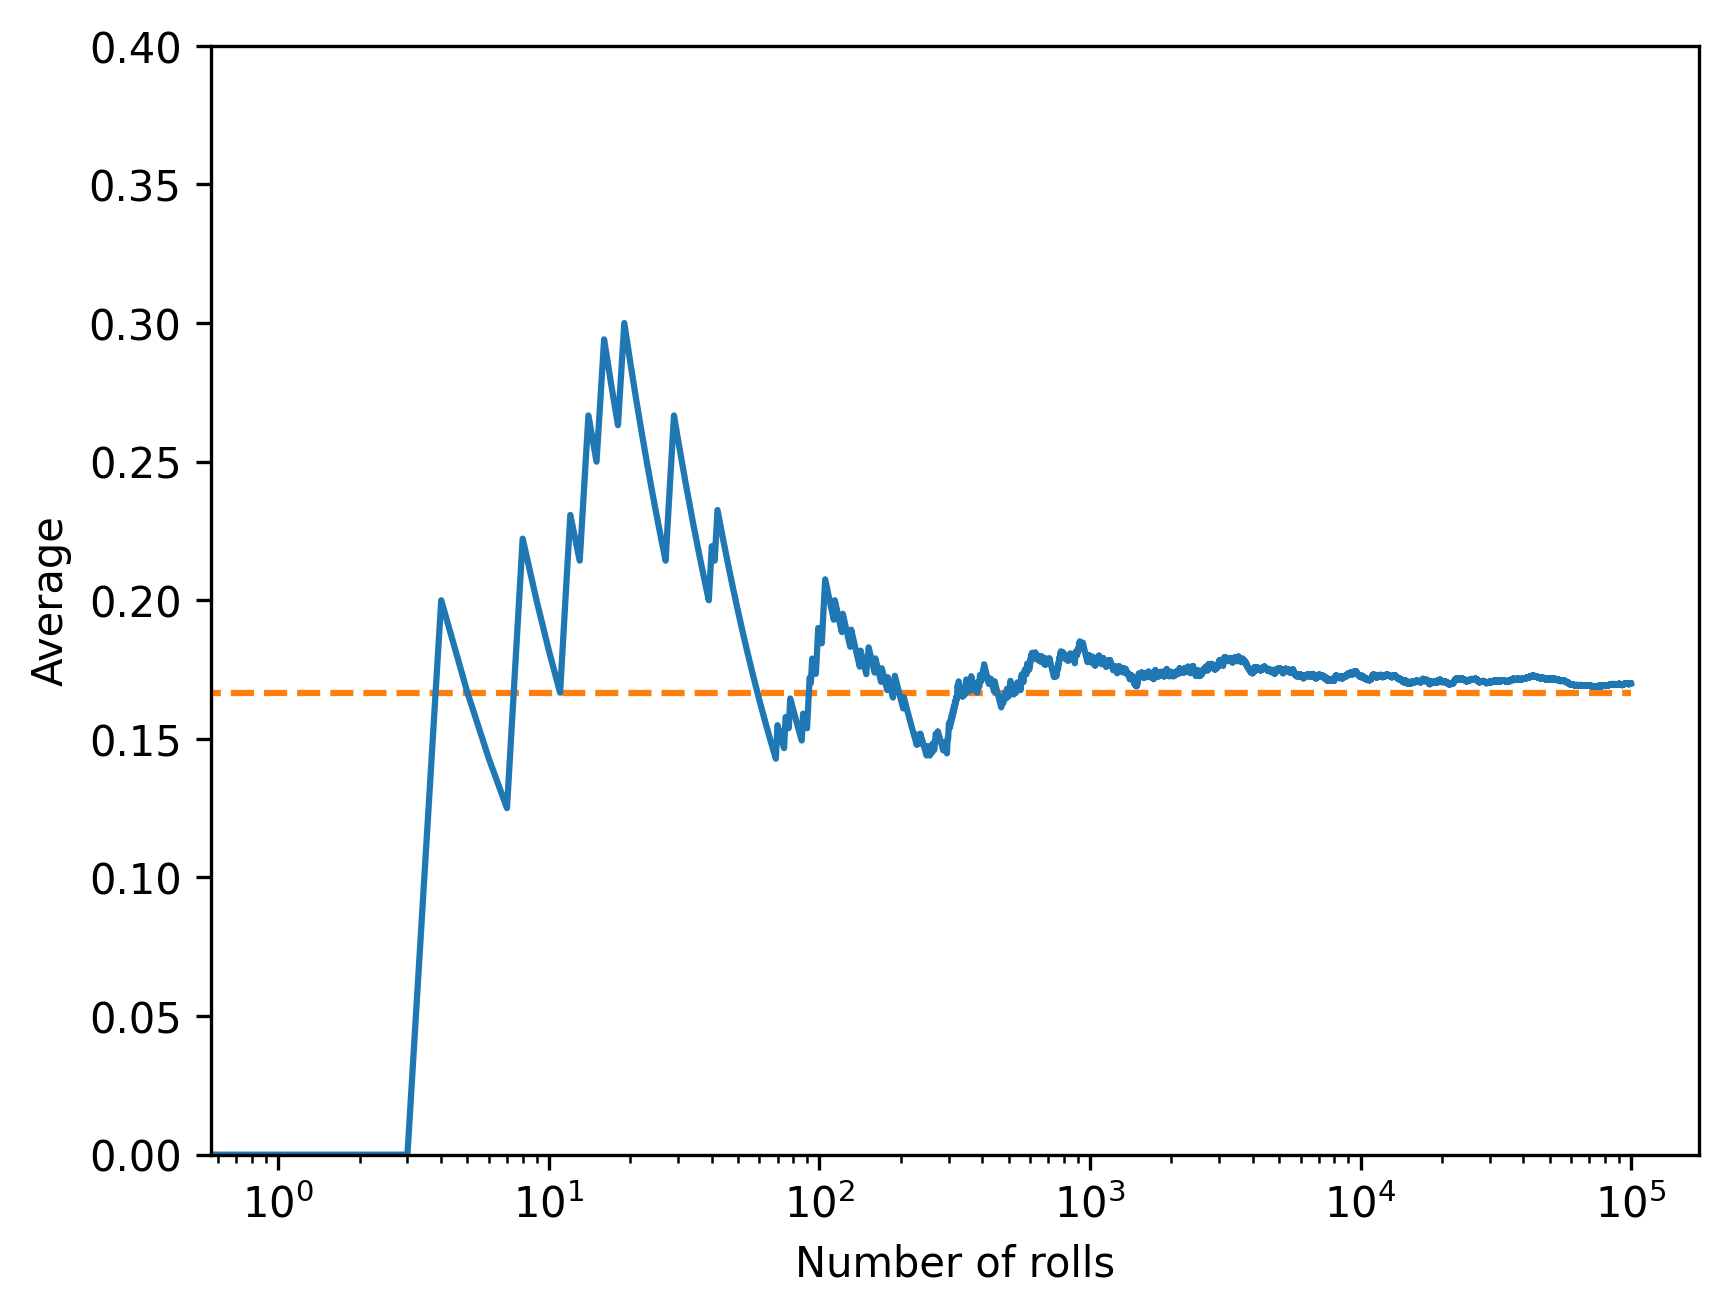

In [7]:
# Roll
num_rolls = 100000
rolls = np.random.randint(1, 7, size=num_rolls)

# Calculate running probability of getting a 1
is_one = (rolls == 1)
cumulative_sum = np.cumsum(is_one)
indices = np.arange(1, num_rolls + 1)
running_probability = cumulative_sum / indices

# Plot
plt.figure(dpi=300)
plt.plot(running_probability)
plt.ylim(0, 0.4)
plt.plot([0, num_rolls], [1/6, 1/6], '--', zorder=-1)
plt.xlabel('Number of rolls')
plt.ylabel('Average')
plt.xscale('log')

## 2. Probability Calibration (not covered in the textbook)

You've been working with machine learning models using scikit-learn for a while now. As you know, when doing classification we can get predictions as class labels (0 or 1 for binary) and we can also get "probabilities" using the `predict_proba()` method. Let's see this on a toy dataset:

In [10]:
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True)
X.shape, y.shape

((569, 30), (569,))

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [13]:
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9574468085106383

In [14]:
# Predicted class label for first datapoint in the test set
clf.predict(X_test[0:1])

array([1])

In [16]:
# Predicted probabilities for each class
clf.predict_proba(X_test[0:1])

array([[0.01, 0.99]])

take a look at the [`predict_proba()` documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict_proba), which in this case is the one for RandomForestClassifier.

Now that you learned probability, think about the following questions:
- Are these values true probabilities?
- How would you assess if these values can be interpreted as probabilities or not?
- Is high test accuracy a justification for using these values as probabilities?

The problem with the metrics you've learned so far (like accuracy, F1-score, etc.) is that they only measure the _discriminative performance_ of the model — how well it distinguishes between different classes. However, these metrics don't tell us anything about the model's _calibration performance_. Say what now? Let me explain.

Calculating accuracy is straightforward: if the model predicts a datapoint as class 0 and the actual label is class 1, then the prediction is incorrect. Repeat this for all the predictions, divide the number of correct predictions by the number of all predictions. Easy enough.

But what about the probabilities the model assigns? For example, suppose the model predicts that a particular datapoint has a 30% probability of being class 0 and a 70% probability of being class 1. Now, if the actual label is class 0, is the model "right" or "wrong"? The answer is: neither! The model is expressing uncertainty, stating that there is a 30% chance the label is 0. So, how do we evaluate this?

The answer lies in the definition of probability itself: when a model assigns a 70% probability to class 1, it means that, in the long run, we should expect 70% of the datapoints predicted with this probability to actually be class 1. In other words, if the model makes 100 predictions where it assigns a 70% probability to class 1, we should see that about 70 of those predictions actually have a class label of 1.

To assess the model's calibration, we can examine all the predictions where the model assigned a 70% probability to class 1 and check how often the actual class label is indeed 1.

In [29]:
y_prob = clf.predict_proba(X_test)

In [30]:
# Only one such prediction
y_prob[y_prob[:, 1]==0.7]

array([[0.3, 0.7]])

In [31]:
X_test.shape

(188, 30)

Given that our test set contains fewer than 200 datapoints, we shouldn't expect many predictions with an exact class probability of 70%. So, what can we do instead? We can broaden the range and check predictions where the probability falls between 60% and 80%, then take the average of these probabilities.

In [33]:
# Predictions where class 1 probability is between 60-80%
# Even with this wide range we don't have much data
# If we had more data we could have kept this range narrower
y_prob_around_07 = y_prob[(0.60 < y_prob[:, 1]) & (y_prob[:, 1] < 0.80)]
y_prob_around_07

array([[0.25, 0.75],
       [0.21, 0.79],
       [0.34, 0.66],
       [0.21, 0.79],
       [0.29, 0.71],
       [0.3 , 0.7 ],
       [0.33, 0.67],
       [0.39, 0.61],
       [0.31, 0.69],
       [0.22, 0.78],
       [0.39, 0.61]])

In [35]:
# Average predicted probability within 60-80 range
np.mean(y_prob_around_07, axis=0)

array([0.29454545, 0.70545455])

In [36]:
print(f'We have {len(y_prob_around_07)} predictions, we expect {100*np.mean(y_prob_around_07, axis=0)[1]:.2f}% of these, {len(y_prob_around_07)*np.mean(y_prob_around_07, axis=0)[1]:.2f}, to have a class label of 1')

We have 11 predictions, we expect 70.55% of these, 7.76, to have a class label of 1


Next, we can examine the corresponding class labels to see how many of them are actually 1:

In [40]:
y_prob_around_07_actual_labels = y_test[(0.60 < y_prob[:, 1]) & (y_prob[:, 1] < 0.80)]
y_prob_around_07_actual_labels

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [41]:
print(f'{np.sum(y_prob_around_07_actual_labels)} out of {len(y_prob_around_07)}, that is {100*np.sum(y_prob_around_07_actual_labels)/len(y_prob_around_07):.2f}% are actually class 1')

10 out of 11, that is 90.91% are actually class 1


This suggests that our model is underconfident (note we don't have much data so we cannot be sure), but this conclusion only applies to the specific range we examined. To fully evaluate the model's calibration, we should analyze all probability ranges ('bins') from 0 to 1, similar to creating a histogram. We can do this with sklearn:

In [42]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_prob[:, 1], n_bins=5)

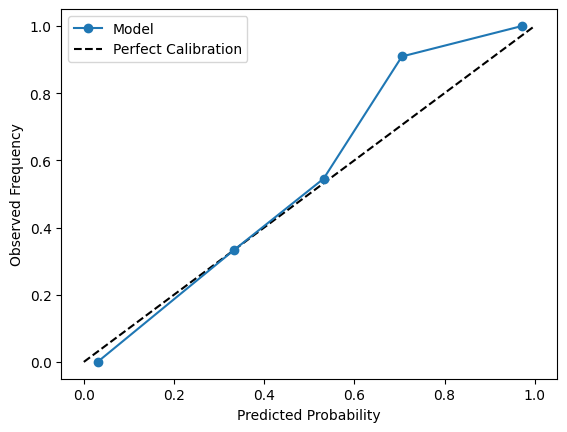

In [46]:
plt.plot(prob_pred, prob_true, linestyle='-', marker='o', label='Model')
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Frequency')
plt.plot([0, 1], [0, 1], 'k--', zorder=-1, label='Perfect Calibration')
plt.legend()

as you can see observed frequency is indeed higher than it should be for perfect calibration, but other regions are just fine. However, this result depends very much on the range we selected (or bins).

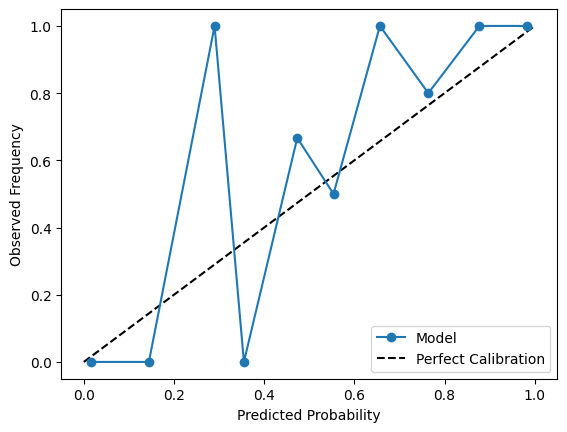

In [47]:
prob_true, prob_pred = calibration_curve(y_test, y_prob[:, 1], n_bins=10)
plt.plot(prob_pred, prob_true, linestyle='-', marker='o', label='Model')
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Frequency')
plt.plot([0, 1], [0, 1], 'k--', zorder=-1, label='Perfect Calibration')
plt.legend()

Now, the results look much worse. So, is our model well-calibrated or not? In other words, can we interpret the outputs of `predict_proba()` as true probabilities?

Notice that if we increase the number of bins (resulting in smaller ranges), each bin will contain only a few datapoints, causing the calibration curve to fluctuate significantly. To address this, we can use `n_bins=5` for this particular case, which suggests that the model's calibration appears acceptable. However, if more reliability is needed, we will require additional data.

**Conclusion:** Before you interpret the model's probabilities as true probabilities, always check its calibration first. If you don't... I'll be smiling through the tears 🥲

Final question, what if your model is not calibrated? Read on:
https://scikit-learn.org/stable/modules/calibration.html